# Fake News Detection


# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import random
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
import nltk
from nltk import UnigramTagger
from collections import Counter
from sklearn import svm
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords

# Importing train and test sets

## Import training dataset

In [2]:
train = pd.read_csv('fake_or_real_news_training.csv')

In [3]:
train.head()

,ID,title,text,label,X1,X2
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,NaN,NaN
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,NaN,NaN
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,NaN,NaN
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,NaN,NaN
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,NaN,NaN


In [4]:
# drop ID since it is useless

train.drop('ID', axis = 1, inplace=True)

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3999 entries, 0 to 3998
Data columns (total 5 columns):
title    3999 non-null object
text     3999 non-null object
label    3999 non-null object
X1       33 non-null object
X2       2 non-null object
dtypes: object(5)
memory usage: 156.3+ KB


In [6]:
# some X1 X2 values contain labels due to poor formatting on the csv file
# I decided to remove them because they constitute a small number compared to the total number of rows

train.drop(train.index[train['X1'].notna()], inplace = True)

In [7]:
train.drop(['X1', 'X2'], axis = 1, inplace=True)

## Import test dataset

In [8]:
test = pd.read_csv('fake_or_real_news_test.csv')

In [9]:
test.head()

,ID,title,text
0,10498,September New Homes Sales Rise——-Back To 1992 ...,September New Homes Sales Rise Back To 1992 Le...
1,2439,Why The Obamacare Doomsday Cult Can't Admit It...,But when Congress debated and passed the Patie...
2,864,"Sanders, Cruz resist pressure after NY losses,...",The Bernie Sanders and Ted Cruz campaigns vowe...
3,4128,Surviving escaped prisoner likely fatigued and...,Police searching for the second of two escaped...
4,662,Clinton and Sanders neck and neck in Californi...,No matter who wins California's 475 delegates ...


In [10]:
test.drop('ID', axis = 1, inplace = True)

In [11]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2321 entries, 0 to 2320
Data columns (total 2 columns):
title    2321 non-null object
text     2321 non-null object
dtypes: object(2)
memory usage: 36.3+ KB


# Feature Extraction and Statistics:

## Word count in each article:

In [12]:
train['word_count'] = train['text'].apply(lambda x: len(str(x).split(" ")))
test['word_count'] = test['text'].apply(lambda x: len(str(x).split(" ")))
train[['text', 'word_count', 'label']].head()

,text,word_count,label
0,"Daniel Greenfield, a Shillman Journalism Fello...",1298,FAKE
1,Google Pinterest Digg Linkedin Reddit Stumbleu...,446,FAKE
2,U.S. Secretary of State John F. Kerry said Mon...,423,REAL
3,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",404,FAKE
4,It's primary day in New York and front-runners...,307,REAL


In [13]:
train[train["label"]=="FAKE"]["word_count"].describe()

count     1976.000000
mean       676.757591
std        873.816021
min          2.000000
25%        222.000000
50%        429.500000
75%        833.000000
max      11353.000000
Name: word_count, dtype: float64

In [14]:
train[train["label"]=="REAL"]["word_count"].describe()

count    1990.000000
mean      852.661307
std       728.481685
min         7.000000
25%       431.500000
50%       754.000000
75%      1094.000000
max      7546.000000
Name: word_count, dtype: float64

Based on the statistics above, real news articles are on average longer than fake news articles. This comparison is done with fewer samples of fake news than real news.

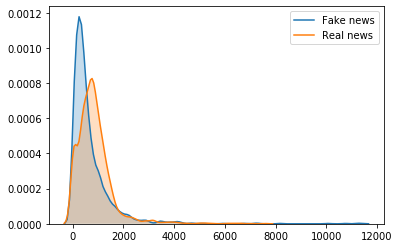

In [15]:
sns.kdeplot(train[train["label"]=="FAKE"]["word_count"], shade = True, label = "Fake news")
sns.kdeplot(train[train["label"]=="REAL"]["word_count"], shade = True, label = "Real news")

As seen in the above figure, articles with a high word count (longer tweets) are more likely to be fake news; fake news articles can reach up to 12,000 words whereas real news articles barely reach 8000. Despite this, most fake news articles have a word count concentrated around the 0 - 1000 range. Real news articles have numbers concentrated mostly in the 0 - 2000 range. There is a marked difference between the distribution of fake and real news articles wordcount. It can be inferred that text length is a determining factor.

## Word count in article titles:

In [16]:
train['word_count_title'] = train['title'].apply(lambda x: len(str(x).split(" ")))
test['word_count_title'] = test['title'].apply(lambda x: len(str(x).split(" ")))
train[['title', 'word_count_title', 'label']].head()

,title,word_count_title,label
0,You Can Smell Hillary’s Fear,5,FAKE
1,Watch The Exact Moment Paul Ryan Committed Pol...,14,FAKE
2,Kerry to go to Paris in gesture of sympathy,9,REAL
3,Bernie supporters on Twitter erupt in anger ag...,15,FAKE
4,The Battle of New York: Why This Primary Matters,9,REAL


In [17]:
train[train["label"]=="FAKE"]["word_count_title"].describe()

count    1976.000000
mean       11.230263
std         4.646176
min         1.000000
25%         8.000000
50%        11.000000
75%        14.000000
max        53.000000
Name: word_count_title, dtype: float64

In [18]:
train[train["label"]=="REAL"]["word_count_title"].describe()

count    1990.000000
mean        9.817588
std         3.189411
min         2.000000
25%         8.000000
50%        10.000000
75%        12.000000
max        27.000000
Name: word_count_title, dtype: float64

Contrary to article length, fake news titles are on average longer than real news ones. 

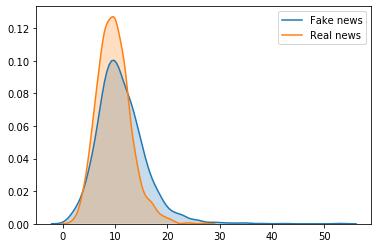

In [19]:
sns.kdeplot(train[train["label"]=="FAKE"]["word_count_title"], shade = True, label = "Fake news")
sns.kdeplot(train[train["label"]=="REAL"]["word_count_title"], shade = True, label = "Real news")

The distributions for fake and real news are quite similar, they mostly overlap. The difference here is that real news have a maximum wordcount of less than 30, whereas fake news titles reach more than 60. It seems that longer titles are associated with fake news.

## Number of English stopwords in each article:

In [20]:
stop = stopwords.words('english')

train['stopwords'] = train['text'].apply(lambda x: len([x for x in x.split() if x in stop]))
test['stopwords'] = test['text'].apply(lambda x: len([x for x in x.split() if x in stop]))
train[['text', 'stopwords', 'label']].head()

,text,stopwords,label
0,"Daniel Greenfield, a Shillman Journalism Fello...",531,FAKE
1,Google Pinterest Digg Linkedin Reddit Stumbleu...,174,FAKE
2,U.S. Secretary of State John F. Kerry said Mon...,172,REAL
3,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",127,FAKE
4,It's primary day in New York and front-runners...,120,REAL


In [21]:
train[train["label"]=="FAKE"]["stopwords"].describe()

count    1976.00000
mean      257.80415
std       353.38284
min         0.00000
25%        77.00000
50%       158.00000
75%       312.25000
max      5045.00000
Name: stopwords, dtype: float64

In [22]:
train[train["label"]=="REAL"]["stopwords"].describe()

count    1990.000000
mean      333.483417
std       286.285227
min         1.000000
25%       167.250000
50%       295.000000
75%       430.750000
max      3270.000000
Name: stopwords, dtype: float64

Similarly to article length, real news article have on average a higher count of English stopwords than fake news ones.

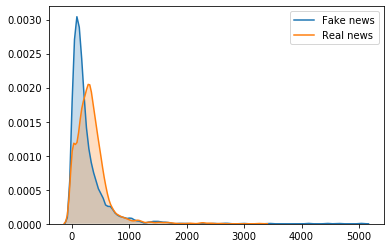

In [23]:
sns.kdeplot(train[train["label"]=="FAKE"]["stopwords"], shade = True, label = "Fake news")
sns.kdeplot(train[train["label"]=="REAL"]["stopwords"], shade = True, label = "Real news")

The real news distribution is shifted to the right compared to the fake news one. This pattern is seen in the length of the article as well where article content distributions for real news is shifted to the right. Here as well, fake news article contain more stopwords.

## English Stopwords in article titles:

In [24]:
train['stopwords_title'] = train['title'].apply(lambda x: len([x for x in x.split() if x in stop]))
test['stopwords_title'] = test['title'].apply(lambda x: len([x for x in x.split() if x in stop]))
train[['title', 'stopwords_title', 'label']].head()

,title,stopwords_title,label
0,You Can Smell Hillary’s Fear,0,FAKE
1,Watch The Exact Moment Paul Ryan Committed Pol...,0,FAKE
2,Kerry to go to Paris in gesture of sympathy,4,REAL
3,Bernie supporters on Twitter erupt in anger ag...,5,FAKE
4,The Battle of New York: Why This Primary Matters,1,REAL


In [25]:
train[train["label"]=="FAKE"]["stopwords_title"].describe()

count    1976.000000
mean        1.426619
std         1.765687
min         0.000000
25%         0.000000
50%         1.000000
75%         2.000000
max        13.000000
Name: stopwords_title, dtype: float64

In [26]:
train[train["label"]=="REAL"]["stopwords_title"].describe()

count    1990.000000
mean        1.914573
std         1.690698
min         0.000000
25%         1.000000
50%         2.000000
75%         3.000000
max        13.000000
Name: stopwords_title, dtype: float64

The statistics for both seem to be quite similar. This can be seen as well in the similarity of both distributions in the graph below.

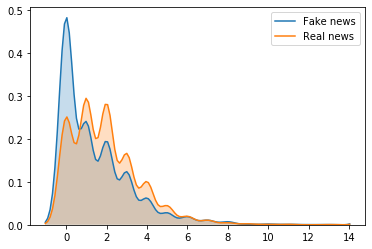

In [27]:
sns.kdeplot(train[train["label"]=="FAKE"]["stopwords_title"], shade = True, label = "Fake news")
sns.kdeplot(train[train["label"]=="REAL"]["stopwords_title"], shade = True, label = "Real news")

Both distributions overlap, but fake news article titles have a higher stopword maximum value.

## Arabic stopwords

In [28]:
stop_ar = stopwords.words('english')

In [29]:
train['ar_stopwords'] = train['text'].apply(lambda x: len([x for x in x.split() if x in stop_ar]))
test['ar_stopwords'] = test['text'].apply(lambda x: len([x for x in x.split() if x in stop_ar]))

In [30]:
train[train['label']=='FAKE']['ar_stopwords'].describe()

count    1976.00000
mean      257.80415
std       353.38284
min         0.00000
25%        77.00000
50%       158.00000
75%       312.25000
max      5045.00000
Name: ar_stopwords, dtype: float64

In [31]:
train[train['label']=='REAL']['ar_stopwords'].describe()

count    1990.000000
mean      333.483417
std       286.285227
min         1.000000
25%       167.250000
50%       295.000000
75%       430.750000
max      3270.000000
Name: ar_stopwords, dtype: float64

Arabic, being one of the most spoken languages in the world is present in those articles. Arabic stopwords are on average more prevalent in real news. But again, a trend seen in previous as well, is that fake news have a higher maximum value for number of stopwords in one article.

## Spanish stopwords

In [32]:
stop_es = stopwords.words('spanish')

In [33]:
train['es_stopwords'] = train['text'].apply(lambda x: len([x for x in x.split() if x in stop_es]))
test['es_stopwords'] = test['text'].apply(lambda x: len([x for x in x.split() if x in stop_es]))

In [34]:
train[train['label']=='FAKE']['es_stopwords'].describe()

count    1976.000000
mean       19.060223
std        24.627574
min         0.000000
25%         5.000000
50%        12.000000
75%        24.000000
max       315.000000
Name: es_stopwords, dtype: float64

In [35]:
train[train['label']=='REAL']['es_stopwords'].describe()

count    1990.000000
mean       30.591960
std        27.260937
min         0.000000
25%        14.000000
50%        25.000000
75%        40.000000
max       248.000000
Name: es_stopwords, dtype: float64

Spanish, is also one of the most spoken languages in the world, as such we have decided to look at it closely. Here also, real news on average contain a higher count of Spanish stopwords. It seems as though a higher count of languages other than English is indicative of real news.

This analysis could be performed as well on Mandarin, French, and Russian, all three of which are widely spoken languages and pertain to parts of the world where major events unfold.

## Number of upper case words in each article:

In [36]:
train['upper'] = train['text'].apply(lambda x: len([x for x in x.split() if x.isupper()]))
test['upper'] = test['text'].apply(lambda x: len([x for x in x.split() if x.isupper()]))
train[['text', 'upper', 'label']].head()

,text,upper,label
0,"Daniel Greenfield, a Shillman Journalism Fello...",38,FAKE
1,Google Pinterest Digg Linkedin Reddit Stumbleu...,3,FAKE
2,U.S. Secretary of State John F. Kerry said Mon...,6,REAL
3,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",5,FAKE
4,It's primary day in New York and front-runners...,3,REAL


In [37]:
train[train["label"]=="FAKE"]["upper"].describe()

count    1976.000000
mean       12.688259
std        20.238552
min         0.000000
25%         3.000000
50%         7.000000
75%        15.000000
max       292.000000
Name: upper, dtype: float64

In [38]:
train[train["label"]=="REAL"]["upper"].describe()

count    1990.000000
mean       10.797487
std        13.971698
min         0.000000
25%         3.000000
50%         7.000000
75%        14.000000
max       146.000000
Name: upper, dtype: float64

Fake news articles have on average more words in upper case than real news ones. Other than that both have almost the same distribution except where fake news have a higher maximum value for number of upper case words in an article. 

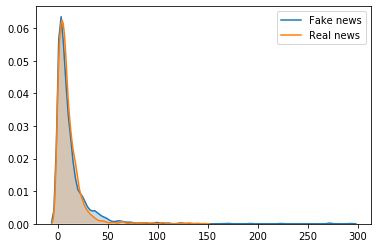

In [39]:
sns.kdeplot(train[train["label"]=="FAKE"]["upper"], shade = True, label = "Fake news")
sns.kdeplot(train[train["label"]=="REAL"]["upper"], shade = True, label = "Real news")

Both distributions almost overlap except that fake news articles have a higher maximum value for upper case words. The association between a higher number of upper case words and fake news can be explained by the fact that upper case usually express hightened emotions, and as such, those heigthened emotions could be associated with a distortion of reality; fake news.

## Number of upper case words in article titles:

In [40]:
train['upper_title'] = train['title'].apply(lambda x: len([x for x in x.split() if x.isupper()]))
test['upper_title'] = test['title'].apply(lambda x: len([x for x in x.split() if x.isupper()]))
train[['title', 'upper_title', 'label']].head()

,title,upper_title,label
0,You Can Smell Hillary’s Fear,0,FAKE
1,Watch The Exact Moment Paul Ryan Committed Pol...,2,FAKE
2,Kerry to go to Paris in gesture of sympathy,0,REAL
3,Bernie supporters on Twitter erupt in anger ag...,1,FAKE
4,The Battle of New York: Why This Primary Matters,0,REAL


In [41]:
train[train["label"]=="FAKE"]["upper_title"].describe()

count    1976.000000
mean        0.745951
std         1.781831
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max        16.000000
Name: upper_title, dtype: float64

In [42]:
train[train["label"]=="REAL"]["upper_title"].describe()

count    1990.000000
mean        0.244221
std         0.503037
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         5.000000
Name: upper_title, dtype: float64

Here as well, fake news titles have on average more upper case letters than real news ones. 

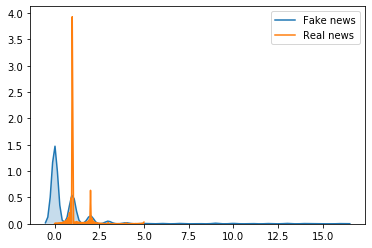

In [43]:
sns.kdeplot(train[train["label"]=="FAKE"]["upper_title"], shade = True, label = "Fake news")
sns.kdeplot(train[train["label"]=="REAL"]["upper_title"], shade = True, label = "Real news")

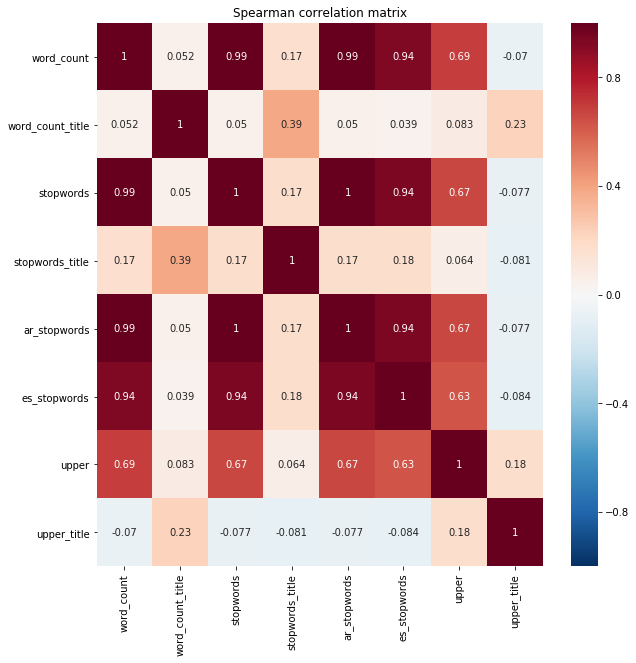

In [44]:
corr_matrix = train.corr(method = 'spearman')
plt.figure(figsize=(10, 10))
ax = sns.heatmap(data = corr_matrix, cmap = "RdBu_r", annot=True, vmin=-1, vmax=1)
ax.set(title='Spearman correlation matrix')
plt.show()

From what we have seen so far, certain aspects are characteristic of one label or the other. For example, upper case words are more common in fake news, be it in the title or the text itself. 

The presence of languages other than English is mostly indicative of real news. Most fake news tend to be written in English. This could be an indication of the intended audience. Or maybe they are written mostly in English because it is the language most widely spoken in the world. Either way this observation is worth noting down.

But what is mostly interesting is that the distributions of those studied characteristics overlap for the titles whereas for texts they are different. It might be best to focus on using the text for predictions. Moreover, all of the characteristics presented above provide insights into the authenticity of the news, it is best not to tamper with them and to leave the texts clean.

# Data Cleaning Functions:

In order to study the effect of each, the title and the text, 3 functions are created.

The first function cleans both the title and the text. The second function cleans the text only. The third function cleans the title only.

As stated above, it seems as though the content of the article, the text, seems to be more important in determining the authenticity of the news. Nonetheless, both text and title will be examined.

## Title and text cleaning:

### Text cleaning:

In [45]:
def clean_text_data(dataframe):

    # Remove punctation
    dataframe['text'] = dataframe['text'].str.replace('[^\w\s]',' ')
    
    # Remove numbers 
    dataframe['text'] = dataframe['text'].str.replace('[^A-Za-z]',' ')
    
    # Make sure any double-spaces are single 
    dataframe['text'] = dataframe['text'].str.replace('  ',' ')
    
    # Transform to lower case
    dataframe['text'] = dataframe['text'].apply(lambda x: " ".join(x.lower() for x in x.split()))
    
    # Remove stopwords
    stop = stopwords.words('english')
    dataframe['text'] = dataframe['text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
    
    return dataframe

### Title cleaning:

In [46]:
def clean_title_data(dataframe):

    # Remove punctation
    dataframe['title'] = dataframe['title'].str.replace('[^\w\s]',' ')
    
    # Remove numbers 
    dataframe['title'] = dataframe['title'].str.replace('[^A-Za-z]',' ')
    
    # Make sure any double-spaces are single 
    dataframe['title'] = dataframe['title'].str.replace('  ',' ')
    
    # Transform to lower case
    dataframe['title'] = dataframe['title'].apply(lambda x: " ".join(x.lower() for x in x.split()))
    
    # Remove stopwords
    stop = stopwords.words('english')
    dataframe['title'] = dataframe['title'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
    
    return dataframe

### Text and Title cleaning:

In [47]:
def clean_data(dataframe):
    
    df = dataframe.copy()
    
    df = clean_text_data(df)
    
    df = clean_title_data(df)
    
    return df

# Labels

Here we save the labels in a variable alone.

In [48]:
labels = train.label
labels.head()

0    FAKE
1    FAKE
2    REAL
3    FAKE
4    REAL
Name: label, dtype: object

In [49]:
train.drop('label', axis = 1, inplace=True)

In [50]:
## Create 2 copies of the original training data
train_original = train.copy()
train2 = train.copy()

In [203]:
## Obtain a clean data set
train_clean = clean_text_data(train_original)

The below dataset contains only the extracted features

In [204]:
train2.drop(['text', 'title'], axis = 1, inplace = True)

# Splitting the data

## Split only text column

In [51]:
x_train, x_test, y_train, y_test = train_test_split(train['text'], labels, test_size=0.2, random_state=7)

## Split only the title column

In [52]:
x_train_title, x_test_title, y_train_title, y_test_title = train_test_split(train['title'], labels, test_size=0.2, random_state=7)

## Clean split

In [53]:
x_train_clean, x_test_clean, y_train_clean, y_test_clean = train_test_split(train['text'], labels, test_size=0.2, random_state=7)

# Vectorizers:

In [54]:
random.seed(3)

In [65]:
#Initialize the TfidfVectorizer
tfidf_vectorizer=TfidfVectorizer(min_df=3, max_features=None,
                                strip_accents='unicode', analyzer='word', token_pattern=r'\w{1,}',
                                ngram_range=(1, 3), use_idf=1, smooth_idf=1, sublinear_tf=1,
                                stop_words='english')

In [72]:
#Initialize the TfidfVectorizer for title data
tfidf_vectorizer_t=TfidfVectorizer(min_df=3, max_features=None,
                                strip_accents='unicode', analyzer='word', token_pattern=r'\w{1,}',
                                ngram_range=(1, 3), use_idf=1, smooth_idf=1, sublinear_tf=1,
                                stop_words='english')

In [73]:
#Initialize the TfidfVectorizer for clean data
tfidf_vectorizer_c=TfidfVectorizer(min_df=3, max_features=None,
                                strip_accents='unicode', analyzer='word', token_pattern=r'\w{1,}',
                                ngram_range=(1, 3), use_idf=1, smooth_idf=1, sublinear_tf=1,
                                stop_words='english')

Although it is a bad practice, but those parameters have provided the best score so far.

## TF-IDF on text column data only

In [66]:
# Fit and transform training data
tfidf_vectorizer.fit(x_train)
tfidf_train = tfidf_vectorizer.transform(x_train)

# Transform the test set
tfidf_test=tfidf_vectorizer.transform(x_test)

#### Clean data:

In [75]:
tfidf_vectorizer_c.fit(x_train_clean)
tf_train_clean = tfidf_vectorizer_c.transform(x_train_clean)
tf_test_clean = tfidf_vectorizer_c.transform(x_test_clean)

## TF-IDF on title column only:

In [76]:
# Fit and transform training data
tfidf_vectorizer_t.fit(x_train_title)
tfidf_train_title = tfidf_vectorizer_t.transform(x_train_title)

# Transform the test set
tfidf_test_title=tfidf_vectorizer_t.transform(x_test_title)

## Apply on the actual test set

In [67]:
# Transform
test_final = tfidf_vectorizer.transform(test['text'])

## Confusion Matrix Function:

In [77]:
# This function takes a test set and predictions as input and outputs a confusion matrix

def plot_confusion_matrix(y_test, y_pred):
    
    # Create a confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_pred)
    
    # name  of classes
    class_names=["REAL","FAKE"] 

    # Set fig and axes 
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)

    # Create heatmap
    sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

# Classification

## Passive Aggressive Classifier

### On text data

In [70]:
# Initialize a PassiveAggressiveClassifier
pac = PassiveAggressiveClassifier(max_iter = 50)
pac.fit(tfidf_train,y_train)

# Predict on the test set and calculate accuracy
y_pred_vec = pac.predict(tfidf_test)
score_vec = accuracy_score(y_test,y_pred_vec)
print(f'Accuracy: {round(score_vec * 100,2)}%')
plot_confusion_matrix(y_test, y_pred_vec)

Accuracy: 94.46%


### On clean text data

In [78]:
# Initialize a PassiveAggressiveClassifier
pac_clean = PassiveAggressiveClassifier(max_iter = 50)
pac_clean.fit(tf_train_clean, y_train_clean)

# Predict on the test set and calculate accuracy
y_pred_clean = pac_clean.predict(tf_test_clean)
clean_score = accuracy_score(y_test_clean,y_pred_clean)
print(f'Accuracy: {round(clean_score * 100,2)}%')

Accuracy: 93.7%


### On title data

In [79]:
# Initialize a PassiveAggressiveClassifier
pac2 = PassiveAggressiveClassifier(max_iter = 50)
pac2.fit(tfidf_train_title,y_train_title)

# Predict on the test set and calculate accuracy
y_pred_vec_title = pac2.predict(tfidf_test_title)
score_vec_title = accuracy_score(y_test_title,y_pred_vec_title)
print(f'Accuracy: {round(score_vec_title * 100,2)}%')
plot_confusion_matrix(y_test_title, y_pred_vec_title)

Accuracy: 75.69%


### Remarks

As seen by the above results, article text is a much better indicator of authenticity. This confirms our initial hypothesis. Moreover, not cleaning the text slightly improves the score obtained. As such keeping the text as it is, is better. In the next sections we will be working only with the text and without cleaning it.

It should be noted that it is highly probable that this model is overfitting. The below models employ a grid search cross validation in an attempt to reduce overfitting.

### Generate predictions:

In [80]:
predictions_final_pac = pac.predict(test_final)

In [82]:
predictions_pac_csv = pd.DataFrame(predictions_final, columns=['predictions']).to_csv('prediction_pac.csv')

Here we try different pipelines and classifiers

## CountVectorizer and Logistric Regression

In [83]:
pipe = Pipeline([('cvec', CountVectorizer()),    
                 ('lr', LogisticRegression(solver='liblinear'))])

pipe_params = {'cvec__stop_words': [None, 'english'],
               'cvec__ngram_range': [(1,1), (2,2), (1,3)],
               'lr__C': [0.01, 1]}

In [84]:
gs = GridSearchCV(pipe, param_grid=pipe_params, cv=3)

In [85]:
gs.fit(x_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('cvec',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                            

In [86]:
print("Best score:", gs.best_score_)

Best score: 0.9082597730138714


The approach taken here is a simple one where we make use of the number of occurences of each word. A simple classifier is used as well; logistic regression. Tuning the parameters of both the vectorizer as well as the regressor allow us to get a better model, and reduce overfitting.

## TF-IDF Vectorizer and Logistic Regression

In [87]:
pipe = Pipeline([
    ('tvect', TfidfVectorizer()),
    ('lr', LogisticRegression(solver='liblinear'))
])

pipe_params = {'tvect__max_df': [.75, .98, 1.0],
               'tvect__min_df': [2, 3, 5],
               'tvect__ngram_range': [(1,1), (1,2), (1,3)],
               'lr__C': [1]}

In [88]:
gs = GridSearchCV(pipe, param_grid=pipe_params, cv=3)

In [89]:
gs.fit(x_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('tvect',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                         

In [90]:
print("Best score:", gs.best_score_)

Best score: 0.8975409836065574


The approach here is quite similar to the previous one but instead of making use of the number of occurences only, we use the weight each word carries; less frequent ones have a bigger weight. The score obtained is lower than the previous one.

## Multinomial Naive Bayes with CountVectorizer

In [91]:
pipe = Pipeline([('cvec', CountVectorizer()),    
                 ('nb', MultinomialNB())])

# Tune GridSearchCV
pipe_params = {'cvec__ngram_range': [(1,1),(1,3)],
               'nb__alpha': [.36, .6]}

In [92]:
gs = GridSearchCV(pipe, param_grid=pipe_params, cv=3)
gs.fit(x_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('cvec',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                            

In [93]:
print("Best score:", gs.best_score_)

Best score: 0.8858764186633039


A lower score is obtained here, one of the possible reasons is because of the assumptions of the multinomial nb. The assumption that the counts follow a multinomial distribution is erroneous and does not reflect the reality of the situation.

## Multinomial Naive Bayes with TF-IDF

In [94]:
pipe = Pipeline([('tvect', TfidfVectorizer()),    
                 ('nb', MultinomialNB())])

# Tune GridSearchCV
pipe_params = {'tvect__max_df': [.75, .98],
               'tvect__min_df': [4, 5],
               'tvect__ngram_range': [(1,2), (1,3)],
               'nb__alpha': [0.1, 1]}

In [95]:
gs = GridSearchCV(pipe, param_grid=pipe_params, cv=5)
gs.fit(x_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('tvect',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                         

In [96]:
print("Best score:", gs.best_score_)

Best score: 0.9066834804539723


A slight improvement is noticed here as we can see. It is possible that the results of the tfdif vectorization fit better the assumptions of the multinomial nb. 

## SVM

In [115]:
params = [
    {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
    {'C': [1, 10, 15, 20], 'gamma': [0.1, 0.15, 0.2, 0.25], 'kernel': ['rbf']}
]

In [116]:
zj = GridSearchCV(estimator=svm.SVC(), param_grid = params, n_jobs = -1)

In [117]:
zj.fit(tfidf_train, y_train)

C:\Users\PC\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid=[{'C': [1, 10, 100, 1000], 'kernel': ['linear']},
                         {'C': [1, 10, 15, 20], 'gamma': [0.1, 0.15, 0.2, 0.25],
                          'kernel': ['rbf']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [118]:
print('Best score for tfidf vectorizer:', zj.best_score_*100)
print('Best C:',zj.best_estimator_.C) 
print('Best Kernel:',zj.best_estimator_.kernel)
print('Best Gamma:',zj.best_estimator_.gamma)

Best score for tfidf vectorizer: 93.5687263556116
Best C: 10
Best Kernel: rbf
Best Gamma: 0.2


The results presented here overfit the least.

### Generate predictions:

In [119]:
predictions_final_svm = zj.predict(test_final)

In [120]:
predictions_final_svm

array(['FAKE', 'REAL', 'REAL', ..., 'FAKE', 'REAL', 'REAL'], dtype=object)

In [121]:
predictions_svm_csv = pd.DataFrame(predictions_final_svm, columns=['predictions']).to_csv('prediction_svm.csv')

# Conclusion

Throughout this work, we have looked at the characteristics of articles and their titles. We looked at their constituents to infer possible relations between them and the authenticity of the news conveyed by the articles. Moreover, it seemed that the content of the articles, the texts, gave better indications than the titles themselves.

These points were confirmed by the results obtained by the many classifiers used. Although the predictions seem to be accurate, different metrics ought to be used. In addition a larger training dataset is required in order to reduce overfitting even more. Given a larger dataset, the use of neural networks could be a good idea to achieve better results.

Lastly, the texts contain many foreign words. Taking those words into account while performing the classification tasks should prove to be useful.